## RNN SCENARIO 2 POD Microservice

In [1]:
#pip install plotly==5.1.0
#at command line execute: 
# conda activate otumba
# conda install scikit-learn scipy matplotlib
# conda install nbformat
# conda install tqdm

In [2]:
import plotly.graph_objects as go 
import numpy as np 
import pandas as pd 

In [3]:
training_filename = 'scenario02-1000000-100-2.csv'
valid_filename = 'scenario02-10000-50-2.csv'
# Data from production
#prod_filename  = 'dataset_10000_500_2.csv'
prod_filename  = 'scenario02-10000-100-2.csv'

In [4]:
train = pd.read_csv(training_filename)
valid = pd.read_csv(valid_filename)
prod = pd.read_csv(prod_filename)
train.head()

,pods,file_descriptors,receive_packets,transmit_packets,dropped_packets,cpu_usage_seconds,cpu_throttled_seconds,memory_working_bytes,memory_usage_bytes,load,date
0,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.550171
1,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.602976
2,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.659358
3,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.701646
4,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.744043


# Standardize Data

In [5]:
from sklearn.preprocessing import StandardScaler
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    df['timestamp'] = pd.to_datetime(df['date'])
    df['stand_value'] = df['memory_working_bytes']
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train)
parse_and_standardize(valid, data_scaler)

parse_and_standardize(prod, data_scaler)

StandardScaler()

In [6]:
#layout = dict(xaxis=dict(title='Timestamp'), yaxis=dict(title='memory_working_bytes')) 
#fig = go.Figure(layout=layout) 
#fig.add_trace(go.Scatter(x=train['timestamp'], y=train['memory_working_bytes'], 
#                         mode='markers', name='Train Non-anomaly',
#                         marker=dict(color='blue')))

In [7]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=valid['timestamp'], y=valid['memory_working_bytes'], 
#                         mode='markers', name='Valid Non-anomaly',
#                         marker=dict(color='blue')))

## LSTM Long Short-Term Memory

In [8]:
import torch 
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class CPUDataset(Dataset):
    def __init__(self, data: pd.DataFrame, size: int):
        self.chunks = torch.FloatTensor(data['stand_value']).unfold(0, size, size)
        
    def __len__(self):
        return self.chunks.size(0)
    
    def __getitem__(self, i):
        x = self.chunks[i]
        return x

train_ds = CPUDataset(train, 64)
valid_ds = CPUDataset(valid, 64)
prod_ds  = CPUDataset(prod, 64)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.device = device
        self.init_hidden()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(
            x.view(len(x), 1, -1), self.hidden_state
        )
        self.hidden_state = tuple(
            [h.detach() for h in self.hidden_state]
        )
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
    
    def init_hidden(self):
        self.hidden_state = (
            torch.zeros((1, 1, self.hidden_size)).to(self.device),
            torch.zeros((1, 1, self.hidden_size)).to(self.device))

In [12]:
def train_model(model: LSTMModel, dataloaders: dict, optimizer: opt.Optimizer, 
                scheduler, criterion, device: torch.device, epochs: int):
    losses_data = {'train': [], 'valid': []}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}/{epochs-1}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.
            running_total = 0.
            
        # Here changes start
            for idx, sequence in enumerate(dataloaders[phase]):
                value = sequence
                value = value.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(value.view(-1, 1))
                    loss = criterion(out.view(-1), value.view(-1))
        # Here changes end

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * out.size(0)
                running_total += out.size(0)

            epoch_loss = running_loss / running_total
            print(f'{phase.capitalize()} Loss: {epoch_loss}')
            losses_data[phase].append(epoch_loss)
    return losses_data

In [13]:
epochs = 200
#model = LSTMModel(1, 512, 1, device)
model = LSTMModel(1, 4096, 1, device)
dataloaders = {
    'train': DataLoader(train_ds, batch_size=1),
    'valid': DataLoader(valid_ds, batch_size=1)
}
optim = opt.Adam(params=model.parameters(), lr=1e-3)
sched = opt.lr_scheduler.OneCycleLR(
  optimizer=optim, max_lr=1e-3, steps_per_epoch=len(dataloaders['train']), epochs=epochs
)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
losses = train_model(model, dataloaders, optim, sched, criterion, device, epochs)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199


  0%|          | 1/200 [01:43<5:44:38, 103.91s/it]

Train Loss: 1.0027877794670097
Valid Loss: 0.028573451430669854
Epoch 1/199


  1%|          | 2/200 [03:29<5:45:32, 104.71s/it]

Train Loss: 0.022057466586971886
Valid Loss: 0.01762007105363799
Epoch 2/199


  2%|▏         | 3/200 [05:12<5:42:00, 104.17s/it]

Train Loss: 0.016344830337914867
Valid Loss: 0.012710572153862034
Epoch 3/199


  2%|▏         | 4/200 [06:56<5:39:29, 103.92s/it]

Train Loss: 0.0206242553881041
Valid Loss: 0.008880964068729165
Epoch 4/199


  2%|▎         | 5/200 [08:39<5:37:14, 103.77s/it]

Train Loss: 0.007268350935356344
Valid Loss: 0.005080952044019276
Epoch 5/199


  3%|▎         | 6/200 [10:23<5:35:16, 103.69s/it]

Train Loss: 0.003338904208710354
Valid Loss: 0.0032668741436542143
Epoch 6/199


  4%|▎         | 7/200 [12:06<5:33:24, 103.65s/it]

Train Loss: 0.003129418618331124
Valid Loss: 0.0017440703647610331
Epoch 7/199


  4%|▍         | 8/200 [13:50<5:31:33, 103.61s/it]

Train Loss: 0.0017318568056466398
Valid Loss: 0.0015334301382868684
Epoch 8/199


  4%|▍         | 9/200 [15:33<5:29:44, 103.58s/it]

Train Loss: 0.0013098951751341985
Valid Loss: 0.000631596236157098
Epoch 9/199


  5%|▌         | 10/200 [17:17<5:27:58, 103.57s/it]

Train Loss: 0.001066849487072256
Valid Loss: 0.00017260508359738327
Epoch 10/199


  6%|▌         | 11/200 [19:00<5:26:12, 103.56s/it]

Train Loss: 0.0014723849723882135
Valid Loss: 0.00036700732640123794
Epoch 11/199


  6%|▌         | 12/200 [20:44<5:24:24, 103.54s/it]

Train Loss: 0.0021471211009427504
Valid Loss: 0.00018838181650997804
Epoch 12/199


  6%|▋         | 13/200 [22:28<5:22:41, 103.54s/it]

Train Loss: 0.0014297705489002372
Valid Loss: 0.0024865929756612915
Epoch 13/199


  7%|▋         | 14/200 [24:11<5:20:57, 103.54s/it]

Train Loss: 0.0009699176550373187
Valid Loss: 0.0010725919148951238
Epoch 14/199


  8%|▊         | 15/200 [25:55<5:19:11, 103.52s/it]

Train Loss: 0.0010312949383374168
Valid Loss: 0.0012098351560000861
Epoch 15/199


  8%|▊         | 16/200 [27:38<5:17:29, 103.53s/it]

Train Loss: 1.4645209846772862
Valid Loss: 0.8992869383655488
Epoch 16/199


  8%|▊         | 17/200 [29:21<5:15:23, 103.40s/it]

Train Loss: 1.8153753574356737
Valid Loss: 0.9209896296794925
Epoch 17/199


  9%|▉         | 18/200 [31:04<5:13:34, 103.37s/it]

Train Loss: 1.8378833364496658
Valid Loss: 1.0856161434203386
Epoch 18/199


 10%|▉         | 19/200 [32:48<5:11:37, 103.30s/it]

Train Loss: 1.8823324607578047
Valid Loss: 1.021671190591795
Epoch 19/199


 10%|█         | 20/200 [34:31<5:09:50, 103.28s/it]

Train Loss: 1.9128222953506726
Valid Loss: 0.8113542635525975
Epoch 20/199


 10%|█         | 21/200 [36:14<5:08:02, 103.25s/it]

Train Loss: 1.9226171584969487
Valid Loss: 0.5878867671958038
Epoch 21/199


 11%|█         | 22/200 [37:57<5:06:13, 103.22s/it]

Train Loss: 1.9183931562776513
Valid Loss: 0.4463673382997513
Epoch 22/199


 12%|█▏        | 23/200 [39:40<5:04:25, 103.19s/it]

Train Loss: 1.9261314748469127
Valid Loss: 0.4377908161176102
Epoch 23/199


 12%|█▏        | 24/200 [41:23<5:02:39, 103.18s/it]

Train Loss: 1.9576285110364893
Valid Loss: 0.6120144320385796
Epoch 24/199


 12%|█▎        | 25/200 [43:07<5:00:53, 103.16s/it]

Train Loss: 1.9989483313896177
Valid Loss: 1.0341962158147777
Epoch 25/199


 13%|█▎        | 26/200 [44:50<4:59:08, 103.16s/it]

Train Loss: 2.0305682750502103
Valid Loss: 1.5013592668942042
Epoch 26/199


 14%|█▎        | 27/200 [46:33<4:57:31, 103.19s/it]

Train Loss: 2.035587831756168
Valid Loss: 1.3703456372022629
Epoch 27/199


 14%|█▍        | 28/200 [48:16<4:55:45, 103.17s/it]

Train Loss: 1.9996911771396535
Valid Loss: 0.5040124974080494
Epoch 28/199


 14%|█▍        | 29/200 [49:59<4:54:07, 103.20s/it]

Train Loss: 1.9075778433431754
Valid Loss: 0.3768598163733259
Epoch 29/199


 15%|█▌        | 30/200 [51:43<4:52:28, 103.23s/it]

Train Loss: 1.75356631685582
Valid Loss: 1.7431465259620122
Epoch 30/199


 16%|█▌        | 31/200 [53:26<4:50:39, 103.19s/it]

Train Loss: 1.5781271165515562
Valid Loss: 2.7114317502294267
Epoch 31/199


 16%|█▌        | 32/200 [55:09<4:48:53, 103.18s/it]

Train Loss: 1.4405005009162684
Valid Loss: 2.288073173591069
Epoch 32/199


 16%|█▋        | 33/200 [56:52<4:47:07, 103.16s/it]

Train Loss: 1.32924653833048
Valid Loss: 1.4232975925718034
Epoch 33/199


 17%|█▋        | 34/200 [58:36<4:46:04, 103.40s/it]

Train Loss: 1.2072455709778889
Valid Loss: 0.8154769646269935
Epoch 34/199


 18%|█▊        | 35/200 [1:00:20<4:44:29, 103.45s/it]

Train Loss: 1.0887629583629896
Valid Loss: 0.43948953449060874
Epoch 35/199


 18%|█▊        | 36/200 [1:02:03<4:42:53, 103.50s/it]

Train Loss: 0.9899742635287163
Valid Loss: 0.23654151904130621
Epoch 36/199


 18%|█▊        | 37/200 [1:03:47<4:41:17, 103.55s/it]

Train Loss: 0.9263535107175166
Valid Loss: 0.2513764293066093
Epoch 37/199


 19%|█▉        | 38/200 [1:05:30<4:39:20, 103.46s/it]

Train Loss: 0.9049059683097033
Valid Loss: 0.29356323315628935
Epoch 38/199


 20%|█▉        | 39/200 [1:07:13<4:37:20, 103.36s/it]

Train Loss: 0.9094379138164428
Valid Loss: 0.30807019557271687
Epoch 39/199


 20%|██        | 40/200 [1:08:56<4:35:27, 103.30s/it]

Train Loss: 0.9258127182225818
Valid Loss: 0.3198271745017597
Epoch 40/199


 20%|██        | 41/200 [1:10:39<4:33:35, 103.24s/it]

Train Loss: 0.9480213706473143
Valid Loss: 0.33606061844953466
Epoch 41/199


 21%|██        | 42/200 [1:12:23<4:31:48, 103.22s/it]

Train Loss: 0.9731438843980552
Valid Loss: 0.3538160914821284
Epoch 42/199


 22%|██▏       | 43/200 [1:14:06<4:29:59, 103.18s/it]

Train Loss: 0.9993961962547823
Valid Loss: 0.3654996869819505
Epoch 43/199


 22%|██▏       | 44/200 [1:15:49<4:28:24, 103.23s/it]

Train Loss: 1.025569616694537
Valid Loss: 0.3624405996607883
Epoch 44/199


 22%|██▎       | 45/200 [1:17:32<4:26:35, 103.19s/it]

Train Loss: 1.0508271082013692
Valid Loss: 0.33956435854945866
Epoch 45/199


 23%|██▎       | 46/200 [1:19:15<4:24:49, 103.18s/it]

Train Loss: 1.0746071083172233
Valid Loss: 0.2998343030256884
Epoch 46/199


 24%|██▎       | 47/200 [1:20:58<4:23:03, 103.16s/it]

Train Loss: 1.0965723125032654
Valid Loss: 0.2558429150709084
Epoch 47/199


 24%|██▍       | 48/200 [1:22:42<4:21:20, 103.16s/it]

Train Loss: 1.1165746896980242
Valid Loss: 0.22712740621396474
Epoch 48/199


 24%|██▍       | 49/200 [1:24:25<4:19:34, 103.14s/it]

Train Loss: 1.134605540536418
Valid Loss: 0.23417590924405626
Epoch 49/199


 25%|██▌       | 50/200 [1:26:08<4:17:51, 103.15s/it]

Train Loss: 1.1507444110434675
Valid Loss: 0.2919756808717336
Epoch 50/199


 26%|██▌       | 51/200 [1:27:51<4:16:07, 103.14s/it]

Train Loss: 1.1651051597024646
Valid Loss: 0.4058556436752302
Epoch 51/199


 26%|██▌       | 52/200 [1:29:34<4:14:24, 103.14s/it]

Train Loss: 1.1777983517023658
Valid Loss: 0.5708112376076835
Epoch 52/199


 26%|██▋       | 53/200 [1:31:17<4:12:40, 103.13s/it]

Train Loss: 1.1889108297914222
Valid Loss: 0.7736322347606931
Epoch 53/199


 27%|██▋       | 54/200 [1:33:00<4:10:57, 103.14s/it]

Train Loss: 1.1985044664850122
Valid Loss: 0.996453155364309
Epoch 54/199


 28%|██▊       | 55/200 [1:34:43<4:09:13, 103.13s/it]

Train Loss: 1.2066251683263203
Valid Loss: 1.2200333625078201
Epoch 55/199


 28%|██▊       | 56/200 [1:36:27<4:07:39, 103.19s/it]

Train Loss: 1.2133055992863437
Valid Loss: 1.4264912051813943
Epoch 56/199


 28%|██▊       | 57/200 [1:38:10<4:05:52, 103.16s/it]

Train Loss: 1.218576241731805
Valid Loss: 1.6006928852626257
Epoch 57/199


 29%|██▉       | 58/200 [1:39:53<4:04:08, 103.16s/it]

Train Loss: 1.2224583064481438
Valid Loss: 1.7309969323022025
Epoch 58/199


 30%|██▉       | 59/200 [1:41:36<4:02:23, 103.14s/it]

Train Loss: 1.224970443989714
Valid Loss: 1.8093321578843253
Epoch 59/199


 30%|███       | 60/200 [1:43:19<4:00:40, 103.14s/it]

Train Loss: 1.2261239586109114
Valid Loss: 1.8311337232589722
Epoch 60/199


 30%|███       | 61/200 [1:45:02<3:58:55, 103.13s/it]

Train Loss: 1.2260881091412705
Valid Loss: 1.8227611354419164
Epoch 61/199


 31%|███       | 62/200 [1:46:46<3:57:12, 103.14s/it]

Train Loss: 1.2257718217912146
Valid Loss: 1.8051428369113378
Epoch 62/199


 32%|███▏      | 63/200 [1:48:29<3:55:36, 103.18s/it]

Train Loss: 1.2252143803090274
Valid Loss: 1.7769265004566737
Epoch 63/199


 32%|███▏      | 64/200 [1:50:12<3:53:51, 103.17s/it]

Train Loss: 1.2243976759626796
Valid Loss: 1.7384100556373596
Epoch 64/199


 32%|███▎      | 65/200 [1:51:55<3:52:05, 103.15s/it]

Train Loss: 1.2233178600161756
Valid Loss: 1.6900571158954076
Epoch 65/199


 33%|███▎      | 66/200 [1:53:38<3:50:21, 103.15s/it]

Train Loss: 1.221976374804983
Valid Loss: 1.6323199995926447
Epoch 66/199


 34%|███▎      | 67/200 [1:55:21<3:48:36, 103.14s/it]

Train Loss: 1.2203693093264827
Valid Loss: 1.5659483075141907
Epoch 67/199


 34%|███▍      | 68/200 [1:57:05<3:46:54, 103.14s/it]

Train Loss: 1.2184953197296695
Valid Loss: 1.4917082573686327
Epoch 68/199


 34%|███▍      | 69/200 [1:58:48<3:45:09, 103.13s/it]

Train Loss: 1.2163506500731684
Valid Loss: 1.410516904933112
Epoch 69/199


 35%|███▌      | 70/200 [2:00:31<3:43:27, 103.13s/it]

Train Loss: 1.2139327484499456
Valid Loss: 1.323438863669123
Epoch 70/199


 36%|███▌      | 71/200 [2:02:14<3:41:42, 103.12s/it]

Train Loss: 1.211239283894437
Valid Loss: 1.2316739580460958
Epoch 71/199


 36%|███▌      | 72/200 [2:03:57<3:40:00, 103.13s/it]

Train Loss: 1.2082665628227707
Valid Loss: 1.1364727105413164
Epoch 72/199


 36%|███▋      | 73/200 [2:05:40<3:38:16, 103.12s/it]

Train Loss: 1.2050092368909182
Valid Loss: 1.039253375359944
Epoch 73/199


 37%|███▋      | 74/200 [2:07:23<3:36:33, 103.13s/it]

Train Loss: 1.2014648472065748
Valid Loss: 0.9414948682699885
Epoch 74/199


 38%|███▊      | 75/200 [2:09:06<3:34:49, 103.12s/it]

Train Loss: 1.1976281381656513
Valid Loss: 0.844737212572779
Epoch 75/199


 38%|███▊      | 76/200 [2:10:49<3:33:07, 103.12s/it]

Train Loss: 1.193495341516799
Valid Loss: 0.7505712083407811
Epoch 76/199


 38%|███▊      | 77/200 [2:12:33<3:31:30, 103.17s/it]

Train Loss: 1.189061611412819
Valid Loss: 0.6605336644819805
Epoch 77/199


 39%|███▉      | 78/200 [2:14:16<3:29:45, 103.16s/it]

Train Loss: 1.1843193877936213
Valid Loss: 0.5761578929211412
Epoch 78/199


 40%|███▉      | 79/200 [2:15:59<3:28:00, 103.14s/it]

Train Loss: 1.1792657538721265
Valid Loss: 0.49884321740163223
Epoch 79/199


 40%|████      | 80/200 [2:17:42<3:26:16, 103.14s/it]

Train Loss: 1.1738930630925426
Valid Loss: 0.42983998341618906
Epoch 80/199


 40%|████      | 81/200 [2:19:25<3:24:32, 103.13s/it]

Train Loss: 1.168195268172293
Valid Loss: 0.3701605577038468
Epoch 81/199


 41%|████      | 82/200 [2:21:08<3:22:49, 103.13s/it]

Train Loss: 1.162164475035415
Valid Loss: 0.32055129297077656
Epoch 82/199


 42%|████▏     | 83/200 [2:22:51<3:21:05, 103.12s/it]

Train Loss: 1.1557939265050048
Valid Loss: 0.28143779574228184
Epoch 83/199


 42%|████▏     | 84/200 [2:24:35<3:19:22, 103.13s/it]

Train Loss: 1.1490769864400094
Valid Loss: 0.2528822964273526
Epoch 84/199


 42%|████▎     | 85/200 [2:26:18<3:17:38, 103.12s/it]

Train Loss: 1.1420049901989024
Valid Loss: 0.23454854253213853
Epoch 85/199


 43%|████▎     | 86/200 [2:28:01<3:15:56, 103.13s/it]

Train Loss: 1.1345696872596198
Valid Loss: 0.22574182001075574
Epoch 86/199


 44%|████▎     | 87/200 [2:29:44<3:14:12, 103.12s/it]

Train Loss: 1.1267659845643594
Valid Loss: 0.2254022035215582
Epoch 87/199


 44%|████▍     | 88/200 [2:31:27<3:12:29, 103.12s/it]

Train Loss: 1.118587212618991
Valid Loss: 0.23217344177620752
Epoch 88/199


 44%|████▍     | 89/200 [2:33:10<3:10:45, 103.12s/it]

Train Loss: 1.1100317147068997
Valid Loss: 0.2444697485438415
Epoch 89/199


 45%|████▌     | 90/200 [2:34:53<3:09:03, 103.12s/it]

Train Loss: 1.1010979012178097
Valid Loss: 0.26058377964156015
Epoch 90/199


 46%|████▌     | 91/200 [2:36:36<3:07:20, 103.12s/it]

Train Loss: 1.091787814827384
Valid Loss: 0.27878457733563017
Epoch 91/199


 46%|████▌     | 92/200 [2:38:20<3:05:36, 103.11s/it]

Train Loss: 1.0821102916470864
Valid Loss: 0.297431869166238
Epoch 92/199


 46%|████▋     | 93/200 [2:40:03<3:03:53, 103.12s/it]

Train Loss: 1.0720781057070154
Valid Loss: 0.3150742868227618
Epoch 93/199


 47%|████▋     | 94/200 [2:41:46<3:02:11, 103.12s/it]

Train Loss: 1.0617087114608093
Valid Loss: 0.33053759964449064
Epoch 94/199


 48%|████▊     | 95/200 [2:43:29<3:00:27, 103.12s/it]

Train Loss: 1.0510298146939574
Valid Loss: 0.3429776555193322
Epoch 95/199


 48%|████▊     | 96/200 [2:45:12<2:58:45, 103.13s/it]

Train Loss: 1.04007219219816
Valid Loss: 0.3518989916358675
Epoch 96/199


 48%|████▊     | 97/200 [2:46:55<2:57:01, 103.12s/it]

Train Loss: 1.0288776859911335
Valid Loss: 0.3571612124464342
Epoch 97/199


 49%|████▉     | 98/200 [2:48:38<2:55:18, 103.12s/it]

Train Loss: 1.0174931983820679
Valid Loss: 0.3589254207909107
Epoch 98/199


 50%|████▉     | 99/200 [2:50:21<2:53:34, 103.12s/it]

Train Loss: 1.0059772438244146
Valid Loss: 0.3576013818383217
Epoch 99/199


 50%|█████     | 100/200 [2:52:05<2:51:52, 103.12s/it]

Train Loss: 0.9943952035454625
Valid Loss: 0.35378111260277884
Epoch 100/199


 50%|█████     | 101/200 [2:53:48<2:50:08, 103.12s/it]

Train Loss: 0.9828239313918585
Valid Loss: 0.3481441257255418
Epoch 101/199


 51%|█████     | 102/200 [2:55:31<2:48:25, 103.12s/it]

Train Loss: 0.9713496877994693
Valid Loss: 0.34139290851141724
Epoch 102/199


 52%|█████▏    | 103/200 [2:57:14<2:46:42, 103.11s/it]

Train Loss: 0.9600722025719612
Valid Loss: 0.33418652282229494
Epoch 103/199


 52%|█████▏    | 104/200 [2:58:57<2:44:59, 103.12s/it]

Train Loss: 0.9491076169060961
Valid Loss: 0.3270852826535702
Epoch 104/199


 52%|█████▎    | 105/200 [3:00:40<2:43:15, 103.12s/it]

Train Loss: 0.9385890590735047
Valid Loss: 0.3205128043357815
Epoch 105/199


 53%|█████▎    | 106/200 [3:02:23<2:41:33, 103.12s/it]

Train Loss: 0.9286734776568275
Valid Loss: 0.31471802826438633
Epoch 106/199


 54%|█████▎    | 107/200 [3:04:06<2:39:49, 103.12s/it]

Train Loss: 0.91954810193178
Valid Loss: 0.3097540935767548
Epoch 107/199


 54%|█████▍    | 108/200 [3:05:49<2:38:07, 103.12s/it]

Train Loss: 0.9114408629036854
Valid Loss: 0.30541910523814814
Epoch 108/199


 55%|█████▍    | 109/200 [3:07:33<2:36:23, 103.11s/it]

Train Loss: 0.9046274381102091
Valid Loss: 0.30119220327053753
Epoch 109/199


 55%|█████▌    | 110/200 [3:09:16<2:34:40, 103.12s/it]

Train Loss: 0.8994499376932089
Valid Loss: 0.29614063033035826
Epoch 110/199


 56%|█████▌    | 111/200 [3:10:59<2:32:57, 103.11s/it]

Train Loss: 0.8963295660352301
Valid Loss: 0.28887975215911865
Epoch 111/199


 56%|█████▌    | 112/200 [3:12:42<2:31:14, 103.12s/it]

Train Loss: 0.8957817111090104
Valid Loss: 0.2777671122125217
Epoch 112/199


 56%|█████▋    | 113/200 [3:14:25<2:29:31, 103.12s/it]

Train Loss: 0.8984148018851058
Valid Loss: 0.2617302004780088
Epoch 113/199


 57%|█████▋    | 114/200 [3:16:08<2:27:48, 103.12s/it]

Train Loss: 0.904906254759103
Valid Loss: 0.24231384428484098
Epoch 114/199


 57%|█████▊    | 115/200 [3:17:51<2:26:04, 103.12s/it]

Train Loss: 0.915925235126693
Valid Loss: 0.22673332850847924
Epoch 115/199


 58%|█████▊    | 116/200 [3:19:34<2:24:22, 103.12s/it]

Train Loss: 0.9319872545842793
Valid Loss: 0.22925115483147757
Epoch 116/199


 58%|█████▊    | 117/200 [3:21:18<2:22:38, 103.12s/it]

Train Loss: 0.9532926472600377
Valid Loss: 0.2660038107008274
Epoch 117/199


 59%|█████▉    | 118/200 [3:23:01<2:20:56, 103.12s/it]

Train Loss: 0.9798015698190454
Valid Loss: 0.34455672897664563
Epoch 118/199


 60%|█████▉    | 119/200 [3:24:44<2:19:12, 103.12s/it]

Train Loss: 1.0118325048545966
Valid Loss: 0.45955540452684673
Epoch 119/199


 60%|██████    | 120/200 [3:26:27<2:17:29, 103.12s/it]

Train Loss: 1.0507734758342537
Valid Loss: 0.6009897158614227
Epoch 120/199


 60%|██████    | 121/200 [3:28:10<2:15:46, 103.12s/it]

Train Loss: 1.0987169301669912
Valid Loss: 0.7686140122158187
Epoch 121/199


 61%|██████    | 122/200 [3:29:53<2:14:03, 103.12s/it]

Train Loss: 1.1567616381312718
Valid Loss: 0.9832787705319268
Epoch 122/199


 62%|██████▏   | 123/200 [3:31:36<2:12:19, 103.11s/it]

Train Loss: 1.2228153367407364
Valid Loss: 1.2836845133985793
Epoch 123/199


 62%|██████▏   | 124/200 [3:33:19<2:10:37, 103.12s/it]

Train Loss: 1.2906463883625767
Valid Loss: 1.682946843760354
Epoch 124/199


 62%|██████▎   | 125/200 [3:35:02<2:08:53, 103.12s/it]

Train Loss: 1.3534396351721911
Valid Loss: 2.118734734398978
Epoch 125/199


 63%|██████▎   | 126/200 [3:36:46<2:07:11, 103.12s/it]

Train Loss: 1.4089309453905023
Valid Loss: 2.4875771829060147
Epoch 126/199


 64%|██████▎   | 127/200 [3:38:29<2:05:28, 103.13s/it]

Train Loss: 1.459846666206382
Valid Loss: 2.694029322692326
Epoch 127/199


 64%|██████▍   | 128/200 [3:40:12<2:03:44, 103.12s/it]

Train Loss: 1.5113031007068194
Valid Loss: 2.655070015362331
Epoch 128/199


 64%|██████▍   | 129/200 [3:41:55<2:02:01, 103.13s/it]

Train Loss: 1.5685346970279477
Valid Loss: 2.313553588730948
Epoch 129/199


 65%|██████▌   | 130/200 [3:43:38<2:00:18, 103.12s/it]

Train Loss: 1.6351144266962643
Valid Loss: 1.6860218048095703
Epoch 130/199


 66%|██████▌   | 131/200 [3:45:21<1:58:35, 103.12s/it]

Train Loss: 1.7111309024752177
Valid Loss: 0.9315872916153499
Epoch 131/199


 66%|██████▌   | 132/200 [3:47:04<1:56:52, 103.12s/it]

Train Loss: 1.7921152245474075
Valid Loss: 0.36094316569090423
Epoch 132/199


 66%|██████▋   | 133/200 [3:48:47<1:55:09, 103.12s/it]

Train Loss: 1.8688026714102066
Valid Loss: 0.2411533689924649
Epoch 133/199


 67%|██████▋   | 134/200 [3:50:31<1:53:26, 103.13s/it]

Train Loss: 1.9302433804804429
Valid Loss: 0.5394499275301184
Epoch 134/199


 68%|██████▊   | 135/200 [3:52:14<1:51:42, 103.12s/it]

Train Loss: 1.971391432945079
Valid Loss: 0.9865596819935101
Epoch 135/199


 68%|██████▊   | 136/200 [3:53:57<1:50:00, 103.13s/it]

Train Loss: 1.9943363252782877
Valid Loss: 1.3367056931768144
Epoch 136/199


 68%|██████▊   | 137/200 [3:55:40<1:48:17, 103.13s/it]

Train Loss: 2.003331096353446
Valid Loss: 1.4831399960177285
Epoch 137/199


 69%|██████▉   | 138/200 [3:57:23<1:46:33, 103.12s/it]

Train Loss: 2.0019855609910033
Valid Loss: 1.4359162471124105
Epoch 138/199


 70%|██████▉   | 139/200 [3:59:06<1:44:50, 103.12s/it]

Train Loss: 1.992974649123311
Valid Loss: 1.2634742707014084
Epoch 139/199


 70%|███████   | 140/200 [4:00:49<1:43:07, 103.12s/it]

Train Loss: 1.978336644643514
Valid Loss: 1.0428603600178445
Epoch 140/199


 70%|███████   | 141/200 [4:02:32<1:41:24, 103.12s/it]

Train Loss: 1.9597495099779725
Valid Loss: 0.8322234725180481
Epoch 141/199


 71%|███████   | 142/200 [4:04:16<1:39:40, 103.12s/it]

Train Loss: 1.9387347391281813
Valid Loss: 0.6629625521600246
Epoch 142/199


 72%|███████▏  | 143/200 [4:05:59<1:37:58, 103.13s/it]

Train Loss: 1.9167734805205678
Valid Loss: 0.5441391909761089
Epoch 143/199


 72%|███████▏  | 144/200 [4:07:42<1:36:15, 103.13s/it]

Train Loss: 1.8953649153515693
Valid Loss: 0.47159954799073084
Epoch 144/199


 72%|███████▎  | 145/200 [4:09:25<1:34:31, 103.12s/it]

Train Loss: 1.8759989107450272
Valid Loss: 0.436733130099518
Epoch 145/199


 73%|███████▎  | 146/200 [4:11:08<1:32:48, 103.12s/it]

Train Loss: 1.8599501512045045
Valid Loss: 0.43229970974581583
Epoch 146/199


 74%|███████▎  | 147/200 [4:12:51<1:31:05, 103.13s/it]

Train Loss: 1.848754520059616
Valid Loss: 0.45423452769007
Epoch 147/199


 74%|███████▍  | 148/200 [4:14:34<1:29:22, 103.12s/it]

Train Loss: 1.842592921985881
Valid Loss: 0.501079335808754
Epoch 148/199


 74%|███████▍  | 149/200 [4:16:17<1:27:39, 103.13s/it]

Train Loss: 1.841391395574813
Valid Loss: 0.5708498103278024
Epoch 149/199


 75%|███████▌  | 150/200 [4:18:01<1:25:55, 103.12s/it]

Train Loss: 1.8438337222724257
Valid Loss: 0.6605542882212571
Epoch 150/199


 76%|███████▌  | 151/200 [4:19:44<1:24:13, 103.12s/it]

Train Loss: 1.8468713029785953
Valid Loss: 0.7600410213427884
Epoch 151/199


 76%|███████▌  | 152/200 [4:21:27<1:22:29, 103.12s/it]

Train Loss: 1.8477693060040332
Valid Loss: 0.8589002093566316
Epoch 152/199


 76%|███████▋  | 153/200 [4:23:10<1:20:46, 103.13s/it]

Train Loss: 1.8447417771876427
Valid Loss: 0.9436621426471642
Epoch 153/199


 77%|███████▋  | 154/200 [4:24:53<1:19:03, 103.13s/it]

Train Loss: 1.837317278674477
Valid Loss: 0.9993187072021621
Epoch 154/199


 78%|███████▊  | 155/200 [4:26:36<1:17:20, 103.12s/it]

Train Loss: 1.8256724516945446
Valid Loss: 1.011300246098212
Epoch 155/199


 78%|███████▊  | 156/200 [4:28:19<1:15:37, 103.13s/it]

Train Loss: 1.8101247940163934
Valid Loss: 0.9697813671082258
Epoch 156/199


 78%|███████▊  | 157/200 [4:30:02<1:13:54, 103.13s/it]

Train Loss: 1.790948485597802
Valid Loss: 0.875006087523486
Epoch 157/199


 79%|███████▉  | 158/200 [4:31:46<1:12:11, 103.12s/it]

Train Loss: 1.7686000988101718
Valid Loss: 0.7399606043472886
Epoch 158/199


 80%|███████▉  | 159/200 [4:33:29<1:10:28, 103.13s/it]

Train Loss: 1.7439065889873016
Valid Loss: 0.5875521099993161
Epoch 159/199


 80%|████████  | 160/200 [4:35:12<1:08:44, 103.12s/it]

Train Loss: 1.7181540088435059
Valid Loss: 0.44196234004838125
Epoch 160/199


 80%|████████  | 161/200 [4:36:55<1:07:01, 103.12s/it]

Train Loss: 1.6925465439295344
Valid Loss: 0.324924764622535
Epoch 161/199


 81%|████████  | 162/200 [4:38:38<1:05:18, 103.12s/it]

Train Loss: 1.6680719854037105
Valid Loss: 0.25037820424352375
Epoch 162/199


 82%|████████▏ | 163/200 [4:40:21<1:03:35, 103.12s/it]

Train Loss: 1.644860617167752
Valid Loss: 0.22462109556155546
Epoch 163/199


 82%|████████▏ | 164/200 [4:42:04<1:01:52, 103.13s/it]

Train Loss: 1.6221306260522943
Valid Loss: 0.24349750857124622
Epoch 164/199


 82%|████████▎ | 165/200 [4:43:47<1:00:09, 103.12s/it]

Train Loss: 1.5986340791135205
Valid Loss: 0.2925146762281656
Epoch 165/199


 83%|████████▎ | 166/200 [4:45:31<58:26, 103.12s/it]  

Train Loss: 1.5735124543545125
Valid Loss: 0.35457350433404955
Epoch 166/199


 84%|████████▎ | 167/200 [4:47:14<56:43, 103.13s/it]

Train Loss: 1.5468876816319725
Valid Loss: 0.4189889327223812
Epoch 167/199


 84%|████████▍ | 168/200 [4:48:57<54:59, 103.12s/it]

Train Loss: 1.5198032799212693
Valid Loss: 0.48371475961591515
Epoch 168/199


 84%|████████▍ | 169/200 [4:50:40<53:16, 103.13s/it]

Train Loss: 1.4937101912240407
Valid Loss: 0.5539301386369127
Epoch 169/199


 85%|████████▌ | 170/200 [4:52:23<51:33, 103.12s/it]

Train Loss: 1.4697864080317087
Valid Loss: 0.6422574711697442
Epoch 170/199


 86%|████████▌ | 171/200 [4:54:06<49:50, 103.12s/it]

Train Loss: 1.4484082168787609
Valid Loss: 0.7693989585552897
Epoch 171/199


 86%|████████▌ | 172/200 [4:55:49<48:07, 103.12s/it]

Train Loss: 1.428600540698454
Valid Loss: 0.9600222408771515
Epoch 172/199


 86%|████████▋ | 173/200 [4:57:32<46:24, 103.12s/it]

Train Loss: 1.4079808061809769
Valid Loss: 1.229842973606927
Epoch 173/199


 87%|████████▋ | 174/200 [4:59:16<44:41, 103.13s/it]

Train Loss: 1.3877836946746378
Valid Loss: 1.573724091053009
Epoch 174/199


 88%|████████▊ | 175/200 [5:00:59<42:57, 103.12s/it]

Train Loss: 1.3654251449422083
Valid Loss: 1.9488089510372706
Epoch 175/199


 88%|████████▊ | 176/200 [5:02:42<41:15, 103.13s/it]

Train Loss: 1.3425649179846058
Valid Loss: 2.287979551724025
Epoch 176/199


 88%|████████▊ | 177/200 [5:04:25<39:31, 103.13s/it]

Train Loss: 1.3200561000664783
Valid Loss: 2.5165647097996304
Epoch 177/199


 89%|████████▉ | 178/200 [5:06:08<37:48, 103.12s/it]

Train Loss: 1.2985587600607205
Valid Loss: 2.580359237534659
Epoch 178/199


 90%|████████▉ | 179/200 [5:07:51<36:05, 103.12s/it]

Train Loss: 1.2785094688826242
Valid Loss: 2.4655940447534834
Epoch 179/199


 90%|█████████ | 180/200 [5:09:34<34:22, 103.12s/it]

Train Loss: 1.2595185114106138
Valid Loss: 2.1947256667273387
Epoch 180/199


 90%|█████████ | 181/200 [5:11:17<32:39, 103.12s/it]

Train Loss: 1.2112099202618933
Valid Loss: 1.9361889958381653
Epoch 181/199


 91%|█████████ | 182/200 [5:13:00<30:56, 103.12s/it]

Train Loss: 1.163990744576877
Valid Loss: 1.545816570520401
Epoch 182/199


 92%|█████████▏| 183/200 [5:14:44<29:12, 103.11s/it]

Train Loss: 1.1433057955035748
Valid Loss: 1.1309747717210226
Epoch 183/199


 92%|█████████▏| 184/200 [5:16:27<27:29, 103.12s/it]

Train Loss: 1.11645841341157
Valid Loss: 0.8598631992936134
Epoch 184/199


 92%|█████████▎| 185/200 [5:18:10<25:46, 103.11s/it]

Train Loss: 1.049511545860219
Valid Loss: 0.6959415461335864
Epoch 185/199


 93%|█████████▎| 186/200 [5:19:53<24:03, 103.12s/it]

Train Loss: 0.9303038745561648
Valid Loss: 0.5161187989371163
Epoch 186/199


 94%|█████████▎| 187/200 [5:21:36<22:20, 103.12s/it]

Train Loss: 0.8229467214751457
Valid Loss: 0.4491477209542479
Epoch 187/199


 94%|█████████▍| 188/200 [5:23:19<20:37, 103.12s/it]

Train Loss: 0.7071877949981987
Valid Loss: 0.32745135815015863
Epoch 188/199


 94%|█████████▍| 189/200 [5:25:02<18:54, 103.12s/it]

Train Loss: 0.5928207965542522
Valid Loss: 0.35414018641625133
Epoch 189/199


 95%|█████████▌| 190/200 [5:26:45<17:11, 103.13s/it]

Train Loss: 0.42559137004982506
Valid Loss: 0.3156507430332048
Epoch 190/199


 96%|█████████▌| 191/200 [5:28:29<15:28, 103.12s/it]

Train Loss: 0.2722865570169891
Valid Loss: 0.2896012174231665
Epoch 191/199


 96%|█████████▌| 192/200 [5:30:12<13:45, 103.13s/it]

Train Loss: 0.16871352254377606
Valid Loss: 0.2561179090823446
Epoch 192/199


 96%|█████████▋| 193/200 [5:31:55<12:01, 103.12s/it]

Train Loss: 0.11404163269036384
Valid Loss: 0.16350737001214707
Epoch 193/199


 97%|█████████▋| 194/200 [5:33:38<10:18, 103.13s/it]

Train Loss: 0.07970024878500578
Valid Loss: 0.11272076198032924
Epoch 194/199


 98%|█████████▊| 195/200 [5:35:21<08:35, 103.12s/it]

Train Loss: 0.06372613615491894
Valid Loss: 0.06333379819989204
Epoch 195/199


 98%|█████████▊| 196/200 [5:37:04<06:52, 103.12s/it]

Train Loss: 0.05454469206849601
Valid Loss: 0.020701553406459943
Epoch 196/199


 98%|█████████▊| 197/200 [5:38:47<05:09, 103.13s/it]

Train Loss: 0.04778523652187319
Valid Loss: 0.0030758562892775182
Epoch 197/199


 99%|█████████▉| 198/200 [5:40:30<03:26, 103.12s/it]

Train Loss: 0.04355615115248525
Valid Loss: 0.0047670468505072805
Epoch 198/199


100%|█████████▉| 199/200 [5:42:14<01:43, 103.13s/it]

Train Loss: 0.04100482397556627
Valid Loss: 0.003755886128471632
Epoch 199/199


100%|██████████| 200/200 [5:43:57<00:00, 103.19s/it]

Train Loss: 0.0397369111462515
Valid Loss: 0.0036721592769026756


In [15]:
train_values = train['stand_value'].values.astype(np.float32).flatten()
valid_values = valid['stand_value'].values.astype(np.float32).flatten()
prod_values  = prod['stand_value'].values.astype(np.float32).flatten()

# Evaluation mode

In [16]:
model.eval()

LSTMModel(
  (lstm): LSTM(1, 4096)
  (linear): Linear(in_features=4096, out_features=1, bias=True)
)

In [17]:
if torch.cuda.is_available():
   model.cuda()

In [18]:
with torch.no_grad():
    res_train = model(torch.tensor(train_values).to(device))
res_train = res_train.cpu()

In [19]:
with torch.no_grad():
    res_valid = model(torch.tensor(valid_values).to(device))
res_valid = res_valid.cpu()

In [20]:
with torch.no_grad():
    res_prod = model(torch.tensor(prod_values).to(device))
res_prod = res_prod.cpu()

## Errors Calculation

In [21]:
def calculate_prediction_errors(target, predicted, criterion):
    reconstruction_errors = []
    for t, p in zip(target, predicted):
        reconstruction_errors = np.append(
            reconstruction_errors, 
            criterion(p, t).cpu().numpy().flatten()
        )
    return reconstruction_errors

train_pred_errors = calculate_prediction_errors(
    res_train.view(-1), torch.tensor(train_values).view(-1), criterion
)
valid_pred_errors = calculate_prediction_errors(
    res_valid.view(-1), torch.tensor(valid_values).view(-1), criterion
)



prod_pred_errors = calculate_prediction_errors(
    res_prod.view(-1), torch.tensor(prod_values).view(-1), criterion
)

## Dynamic Threshold

In [22]:
window = 55
std_coef= 7

train_pred_errors_windowed = pd.Series(train_pred_errors).rolling(window=window, min_periods=1)
train_dynamic_threshold = train_pred_errors_windowed.mean() + std_coef * train_pred_errors_windowed.std()

valid_pred_errors_windowed = pd.Series(valid_pred_errors).rolling(window=window, min_periods=1)
valid_dynamic_threshold = valid_pred_errors_windowed.mean() + std_coef * valid_pred_errors_windowed.std()


prod_pred_errors_windowed = pd.Series(prod_pred_errors).rolling(window=window, min_periods=1)
prod_dynamic_threshold = prod_pred_errors_windowed.mean() + std_coef * prod_pred_errors_windowed.std()

## Metric Calculation

In [23]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

## Anomaly Detection

In [24]:
from typing import Union
def detect_anomalies( result: torch.Tensor, dataset: CPUDataset, threshold: Union[float, pd.Series], n_factors: int = 0):
    anomalies_idxs = []
    for i in range(len(dataset)):
        if type(threshold) == pd.Series:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold[i])
        else:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold)
        if is_anomaly:
            anomalies_idxs.append(i + n_factors)
    return anomalies_idxs

In [25]:
train_anomalies_idxs = detect_anomalies(res_train, torch.tensor(train_values), train_dynamic_threshold)
valid_anomalies_idxs = detect_anomalies(res_valid, torch.tensor(valid_values), valid_dynamic_threshold)

prod_anomalies_idxs  = detect_anomalies(res_prod, torch.tensor(prod_values), prod_dynamic_threshold)



/home/peter/anaconda3/envs/otumba/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [26]:
train_anomalies_idxs 
len(train_anomalies_idxs)


989

In [27]:
valid_anomalies_idxs
len(valid_anomalies_idxs)

5

In [28]:
prod_anomalies_idxs
len(prod_anomalies_idxs)

0

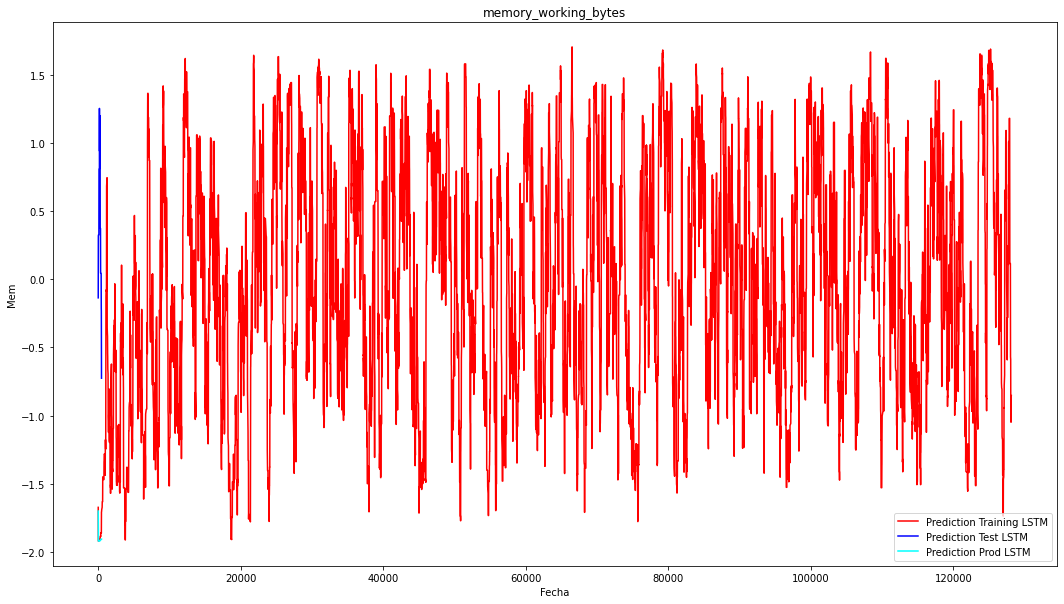

In [29]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(10)
plt.plot(res_train, color = 'red', label = 'Prediction Training LSTM')
plt.plot(res_valid, color = 'blue', label = 'Prediction Test LSTM')
plt.plot(res_prod, color = 'cyan', label = 'Prediction Prod LSTM')
plt.title("memory_working_bytes")
plt.xlabel("Fecha")
plt.ylabel("Mem")
plt.legend()
plt.show()

In [30]:
torch.save(model, "scen02-mem-210907-20-06-4096-ep200")

## 